# Information Sampling Task Analysis (Comparison to Hunt)
Here, we explain how the IST is analyzed and compare the output from our own script to Hunt's.

In [ ]:
import itertools
import pandas as pd
import numpy as np
# Calculating which row wins in each possible game
cards = list(range(1,11))
games = list(itertools.product(cards, repeat=4))
games = pd.DataFrame(games, columns = [1,2,3,4])
# In each of the games row A either wins or loses
games['row_a'] = games[[1,2]].sum(axis = 1)
games['row_b'] = games[[3,4]].sum(axis = 1)
games['row_a_wins'] = games.row_a > games.row_b # Note that ties are allowed
games['row_b_wins'] = games.row_a < games.row_b



# A dataframe with all possible states
states_0 = [()] # No card revealed at stage 0
states_1 = list(itertools.product(cards, repeat=1))
states_2 = list(itertools.product(cards, repeat=2))
states_3 = list(itertools.product(cards, repeat=3))
states_4 = list(itertools.product(cards, repeat=4))
states = states_0 + states_1 + states_2 + states_3 + states_4
states = pd.DataFrame({'state':states})
states['stage'] = states.state.apply(lambda x: len(x))
states['total_turn_cost'] = states.stage.apply(lambda x: np.sum([0,10,15,20][:x]))

# Calculating p_win for each state
def get_p_win(state):
    state = {location+1:value for location,value in enumerate(list(state))}
    possible_games = games.loc[(games[list(state)] == pd.Series(state)).all(axis=1)]
    p_a_win = possible_games.row_a_wins.mean()
    p_b_win = possible_games.row_b_wins.mean()
    
    choice = 'row_a_wins' if p_a_win > p_b_win else 'row_b_wins'
    
    p_win = possible_games[choice].mean()
    
    return p_win

states['p_win'] = states.state.apply(get_p_win)
states['q_s_guess'] = states.p_win*60-(1-states.p_win)*50-states.total_turn_cost


df = states

In [ ]:
df = states
def choose_best_action(df):
    # This will fail if q_s_guess equals q_s_seek
    df['best_action'] = (df['q_s_guess'] > df['q_s_seek']).replace({True:"guess",False:"seek"})
    df.loc[df.q_s_guess.isnull() | df.q_s_seek.isnull(), 'best_action'] = np.nan
    df['expected_best_value'] = df[['q_s_guess','q_s_seek']].max(axis=1)
    df.loc[df.q_s_guess.isnull() | df.q_s_seek.isnull(), 'expected_best_value'] = np.nan
    # We do not allow seeking in stage 4
    states.loc[states.stage==4,'best_action'] = 'guess'
    return df

def get_q_s_seek(state):
    if len(state) == 4:
        return -np.inf # We do not allow seeking in stage 4
    expected_best_values = []
    for i in range(1,11):
        next_state = state + (i,)
        expected_best_values.append(df[df.state==next_state].expected_best_value)
    return np.mean(expected_best_values)

#df.loc[df.stage==4, 'q_s_guess'] = 15 # This is incorrect (but implied in Hunt's paper)

for stage in range(4,-1,-1): # Looping through stage 4 to 0
    df.loc[df.stage==stage, 'q_s_seek'] = df.loc[df.stage==stage].state.apply(get_q_s_seek)
    df = choose_best_action(df)

display(df.groupby('stage').tail(3))

,state,stage,total_turn_cost,p_win,q_s_guess,q_s_seek,best_action,expected_best_value
0,(),0,0.0,0.4665,1.315,24.912,seek,24.912
8,"(8,)",1,0.0,0.6480,21.280,21.980,seek,21.980
9,"(9,)",1,0.0,0.7170,28.870,25.340,guess,28.870
10,"(10,)",1,0.0,0.7800,35.800,29.140,guess,35.800
108,"(10, 8)",2,10.0,0.9400,43.400,28.600,guess,43.400
109,"(10, 9)",2,10.0,0.9700,46.700,31.700,guess,46.700
110,"(10, 10)",2,10.0,0.9900,48.900,33.900,guess,48.900
1108,"(10, 10, 8)",3,25.0,1.0000,35.000,15.000,guess,35.000
1109,"(10, 10, 9)",3,25.0,1.0000,35.000,15.000,guess,35.000
1110,"(10, 10, 10)",3,25.0,0.9000,24.000,4.000,guess,24.000


,state,stage,total_turn_cost,p_win,q_s_guess,q_s_seek,best_action,expected_best_value,first_card,rel_val
1,"(1,)",1,0.0,0.780,35.80,29.14,guess,35.80,1,6.66
2,"(2,)",1,0.0,0.717,28.87,25.34,guess,28.87,2,3.53
3,"(3,)",1,0.0,0.648,21.28,21.98,seek,21.98,3,-0.70
4,"(4,)",1,0.0,0.575,13.25,19.56,seek,19.56,4,-6.31
5,"(5,)",1,0.0,0.500,5.00,18.35,seek,18.35,5,-13.35
6,"(6,)",1,0.0,0.500,5.00,18.35,seek,18.35,6,-13.35
7,"(7,)",1,0.0,0.575,13.25,19.56,seek,19.56,7,-6.31
8,"(8,)",1,0.0,0.648,21.28,21.98,seek,21.98,8,-0.70
9,"(9,)",1,0.0,0.717,28.87,25.34,guess,28.87,9,3.53
10,"(10,)",1,0.0,0.780,35.80,29.14,guess,35.80,10,6.66


<AxesSubplot:xlabel='first_card'>

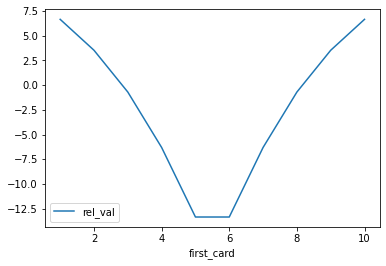

In [ ]:
test = df.query('stage==1')
test['first_card'] = test.state.apply(lambda x: list(x)[0])
test['rel_val'] = test.q_s_guess - test.q_s_seek
display(test)
test.plot(x='first_card',y='rel_val')

<img src="images/dynamic_programming_stage_1.png" alt="Drawing" style="width: 600px; border-right:10px solid white"/>

Expected: 1: 6, 2: 2.42, 3:-2.52, 4: -8.6

This almost matches for the first-card cases.  In the next step, I could compare data created from my model (e.g. optimum turns) against that of Hunt, by importing a few of his trials and associated outputs.

# Comparing to Hunt

Getting optimal turns from Hunt (see SST Hunt Script Notebook): 

In [ ]:
with open('opt_string.txt','r') as f: # This file is produced based on infotask_dyprog_AA_trials.m from Hunt
    optimal_turns = f.read()
# Getting optimal turns from Hunt's model
ot = optimal_turns.split('\n')
ot = [x.split(':') for x in ot][:-1]
ot = {eval(x[0]):int(x[1]) for x in ot}

Calculating based on my model:

In [ ]:
turn_dict[(5,)]

False

In [ ]:
ot

In [ ]:
turn_dict = dict(zip(states.state, states.best_action=='guess'))

In [ ]:
ot2 = {}
for i in range(1, 11):
    for j in range(1, 11):
        for k in range(1, 11):
            for l in range(1, 11):
                state = (i,j,k,l)
                if turn_dict[(i,)]:
                    ot2[state] = 1
                elif turn_dict[(i,j)]:
                    ot2[state] = 2
                elif turn_dict[(i,j,k)]:
                    ot2[state] = 3
                else:
                    ot2[state] = 4

    

Hunt and I predict the same number of optimal turns.

In [ ]:
ot

{(1, 1, 1, 1): 1,
 (1, 1, 1, 2): 1,
 (1, 1, 1, 3): 1,
 (1, 1, 1, 4): 1,
 (1, 1, 1, 5): 1,
 (1, 1, 1, 6): 1,
 (1, 1, 1, 7): 1,
 (1, 1, 1, 8): 1,
 (1, 1, 1, 9): 1,
 (1, 1, 1, 10): 1,
 (1, 1, 2, 1): 1,
 (1, 1, 2, 2): 1,
 (1, 1, 2, 3): 1,
 (1, 1, 2, 4): 1,
 (1, 1, 2, 5): 1,
 (1, 1, 2, 6): 1,
 (1, 1, 2, 7): 1,
 (1, 1, 2, 8): 1,
 (1, 1, 2, 9): 1,
 (1, 1, 2, 10): 1,
 (1, 1, 3, 1): 1,
 (1, 1, 3, 2): 1,
 (1, 1, 3, 3): 1,
 (1, 1, 3, 4): 1,
 (1, 1, 3, 5): 1,
 (1, 1, 3, 6): 1,
 (1, 1, 3, 7): 1,
 (1, 1, 3, 8): 1,
 (1, 1, 3, 9): 1,
 (1, 1, 3, 10): 1,
 (1, 1, 4, 1): 1,
 (1, 1, 4, 2): 1,
 (1, 1, 4, 3): 1,
 (1, 1, 4, 4): 1,
 (1, 1, 4, 5): 1,
 (1, 1, 4, 6): 1,
 (1, 1, 4, 7): 1,
 (1, 1, 4, 8): 1,
 (1, 1, 4, 9): 1,
 (1, 1, 4, 10): 1,
 (1, 1, 5, 1): 1,
 (1, 1, 5, 2): 1,
 (1, 1, 5, 3): 1,
 (1, 1, 5, 4): 1,
 (1, 1, 5, 5): 1,
 (1, 1, 5, 6): 1,
 (1, 1, 5, 7): 1,
 (1, 1, 5, 8): 1,
 (1, 1, 5, 9): 1,
 (1, 1, 5, 10): 1,
 (1, 1, 6, 1): 1,
 (1, 1, 6, 2): 1,
 (1, 1, 6, 3): 1,
 (1, 1, 6, 4): 1,
 (1, 1, 6, 5): 1,
 (1, 

In [ ]:
print(ot == ot2)

True


To run trial-by-trial, first calculate diff score between optimal and actual and the use as dependent.